In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 

from matplotlib.ticker import ScalarFormatter

tfd=tfp.distributions

Calculate gravity of polygon

" Computing the gravitaional and magnetic anomalies due to a polygon: Algorithems and Fortran subroutines' Won 1986


In [15]:
def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)

def B(x,z,p1,p2):
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))

def theta(x,z, p):
    if x[p] != 0 :
        if(np.arctan(z[p]/x[p]))<0:
            return(np.arctan(z[p]/x[p])+scipy.pi)
        else:
            return(np.arctan(z[p]/x[p]))
    if x[p] == 0 and z[p]!=0 :
        return(scipy.pi/2)

def r(x,z,p):
    return(np.sqrt(x[p]**2+z[p]**2))

def Z(x,z,p1,p2):
    
    if x[p1] == z[p1]==0 or x[p2] == z[p2]==0:
        return(0)
    
    if x[p1] == x[p2]:
        return((x[p1]*np.log(r(x,z,p2)/r(x,z,p1))))
    
    theta1 = theta(x,z, p1)
    theta2 = theta(x,z, p2)
    
    r1 = r(x,z,p1)
    r2 = r(x,z,p2)
    
    #this is only needed when observation location across z
#     if z[p1]*z[p2]<0:
#         if x[p1]*z[p2]==x[p2]*z[p1]:
#             return(0)
#         if x[p1]*z[p2] < x[p2]*z[p1] and z[p2]>=0:
#             theta1 += 2*scipy.pi
#         if x[p1]*z[p2] > x[p2]*z[p1] and z[p1]>=0:
#             theta2 += 2*scipy.pi
    
    _A = A(x,z,p1,p2)
    _B = B(x,z,p1,p2)
    
    Z_result = _A*((theta1-theta2)+_B*np.log(r1/r2))
    return(Z_result)

Gravity at origin is calculated as $\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}$
(Won, 1987)

In [16]:
def g(data,loc=(0,0)):
    
    G = 6.67 * 10**(-11) # gravitational constant  m^3 kg ^-1 s^-2
    rho = 1000        # density difference   kg/m^3
    
    _data = data - loc #Calculate any point refer to the origin

    _x = _data[:,0]
    _z = _data[:,1]

    Z_sum = 0
    
    for i in range(_data.shape[0]-1):
        Z_sum += Z(_x,_z,i,i+1)

    Z_sum += Z(_x,_z,-1,0)

    g = 2*G*rho * Z_sum
    
    return(g)

In [17]:
def draw(points,ax = None,R = 100):
    if ax == None:
        f,ax=plt.subplots()
    x = points[:,0]
    z = points[:,1]
    for i in range(points.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'r-')
    x_ = np.linspace(-R,R,10)
    ax.plot(x_,np.zeros(np.shape(x_)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'r-')
    ax.set_ylim(min(points[:,1])-10,5)
    ax.set_xlim(-R,R)
    
def grav_calculate(points_,x=None, R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x is None:
        x = np.linspace(-R,R,501)
    y = np.zeros(np.shape(x))
    obv = np.vstack((x,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(points_,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.plot(x,gravity,style,**args)
    
    return gravity
    
def plot_true(points,R = None,ax = None):
    if R is None:
        R =max(points[:,0])
    if ax is None:
        f , ax = plt.subplots(2 , sharex = True, figsize = (7,10))
    
    ax[0].set_title('gravity response at surface')
    ax[0].set_ylabel('g_z ($m/s^2$ )')
    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    grav_calculate(points, R=max(points[:,0]),ax = ax[0])

    ax[1].set_title('subsurface geometry')
    ax[1].set_ylabel('Z (m)')
    ax[1].set_xlabel('surface position (m)')
    
    draw(points,ax = ax[1],R=R)
    
    

<b> "note: if z is positive downward and x is positive to the right, then the polygen vertices must be specified clock-wise. " --Won 1987

In [18]:
#define a pseudo boundary condition and corner points
depth = -20
thickness = 20

corners=np.array([[-200,depth-thickness],
                  [-70,depth-thickness],
                  [70,depth-thickness],# bottom left coner
              [200,depth-thickness], 
              [200,depth], # bottom right coner
              [70, depth], # top right coner
              [-70,depth],# top left coner
              [-200,depth]])
N = 10
points = np.empty((2*N+8,2))

points[0] = corners[0]
points[1] = corners[1]

for i in range(6):
    points[N+i] = corners[i]
    
points[-2]=corners[-2]
points[-1]=corners[-1]

np.random.seed(11)

x2 = np.linspace(-70,70,N+2)
x1 = np.linspace(70,-70,N+2)

thickness = 20
y1 = np.random.uniform(-2,-50,N)
y2 = y1-thickness


In [19]:
y1 = list(reversed(y1))
y_0 = y1

In [20]:
for i in range(2,N+2): ## lower layer
    points[i][1] = y2[i-2]
    points[i][0] = x2[i-1]
    
for i in range(N+6,2*N+6): ## upper layer
    points[i][1] = y1[i-N-6]
    points[i][0] = x1[i-N-5]

In [21]:
points[:,0][N+6:-2]

array([ 57.27272727,  44.54545455,  31.81818182,  19.09090909,
         6.36363636,  -6.36363636, -19.09090909, -31.81818182,
       -44.54545455, -57.27272727])

In [22]:
y3= (points[:,1][1:N+3]+70)*10
y3

array([300.        , 393.47054934, 470.65188409, 257.65510728,
       132.03171399, 278.3022698 , 246.99499288, 473.865209  ,
       246.06162849,  27.93280688,  71.6183571 , 300.        ])

In [23]:
import copy
points_copy = copy.deepcopy(points)

In [27]:
points = np.array([[-200.      ,  -40.      ],
       [ -70.      ,  -40.      ],
       [ -46.666668,  -24.338795],
       [ -23.333334,  -35.877262],
       [   0.      ,  -56.606384],
       [  23.333334,  -23.03758 ],
       [  46.666668,  -31.884293],
       [  70.      ,  -40.      ],
       [ 200.      ,  -40.      ],
       [ 200.      ,  -20.      ],
       [  70.      ,  -20.      ],
       [  46.666668,  -11.884293],
       [  23.333334,   -3.03758 ],
       [   0.      ,  -36.606384],
       [ -23.333334,  -15.877264],
       [ -46.666668,   -4.338794],
       [ -70.      ,  -20.      ],
       [-200.      ,  -20.      ]])

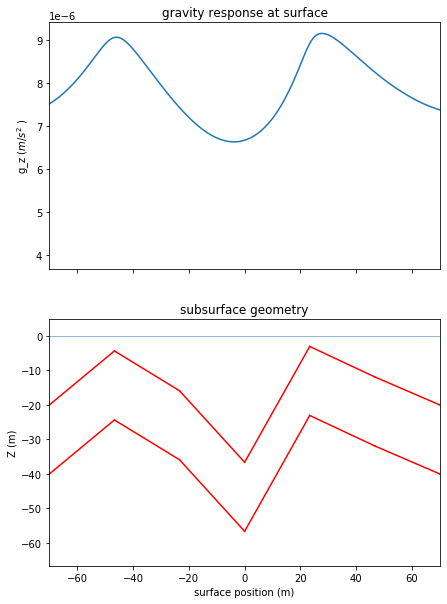

In [28]:
plot_true(points,70)


In [25]:
x_obs = np.linspace(-70., 70., 11)
x_obs = x_obs[1:-1]
obs_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.',linewidth=10)

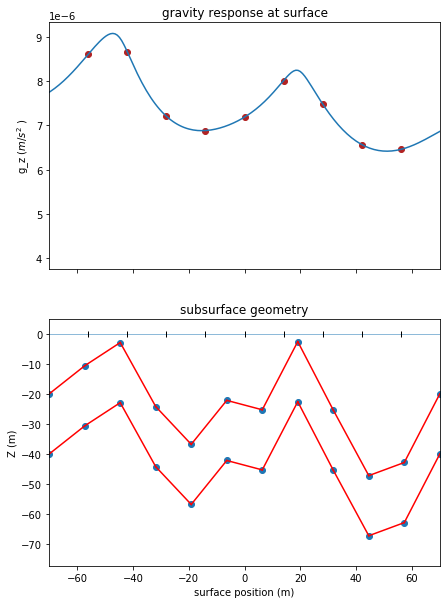

In [26]:

f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)
grav_calculate(points,x=x_obs,ax = ax[1],style='k|',linewidth=10)#receivers position
ax[1].scatter(points[:,0],points[:,1])
ax[0].scatter(x_obs,obs_data,color='firebrick')

# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/model.png')

In [27]:
noise = norm(0,0.0000003).rvs(len(obs_data))
grav_obs_withnoise = obs_data+noise

9 observation points,10 parameters

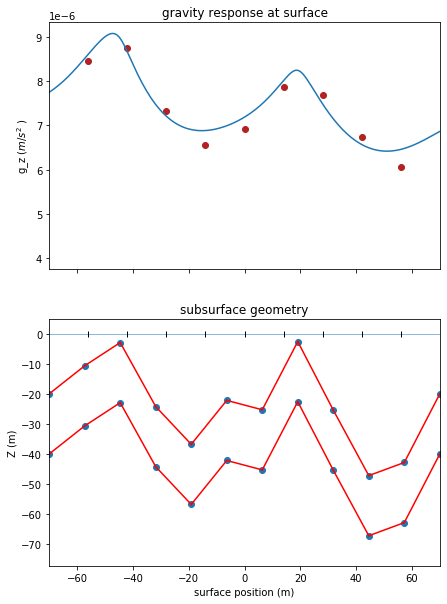

In [28]:
f,ax = plt.subplots(2,sharex = True,figsize = (7,10))
plot_true(points,70,ax)

grav_calculate(points,x=x_obs,ax = ax[1],style='k|',linewidth=10)#receivers position
ax[0].scatter(x_obs,grav_obs_withnoise,color='firebrick')
ax[1].scatter(points[:,0],points[:,1])
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/model_addNoise.png')

In [29]:
dtype = tf.float32

In [ ]:
obs_data = grav_calculate(points,x=x_obs,ax = ax[0],style='.')

In [30]:
def grav(base,ps):
    
    ps1 = ps
    ps2 = ps1-thickness

    ps2 = list(reversed(ps2))
    
    base_ = copy.deepcopy(base)
    
    for i in range(2,N+2): ## lower layer
        base_[i][1] = ps2[i-2]
    
    for i in range(N+6,2*N+6): ## upper layer
        base_[i][1] = ps1[i-N-6]

    x_obv = np.linspace(-70., 70., 11)
    y_obv = np.zeros(np.shape(x_obv))
    obv = np.vstack((x_obv,y_obv)).T
    
    gravity = []
    for i in obv[1:-1]:
        gravity.append(-g(base,i))
        
    return gravity



In [31]:
obs_data

array([8.60896987e-06, 8.66312399e-06, 7.20580082e-06, 6.88169954e-06,
       7.18569271e-06, 8.01242966e-06, 7.48385885e-06, 6.56599289e-06,
       6.45516422e-06])

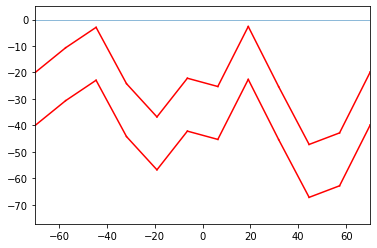

In [33]:
draw(points_copy,R=70)

In [86]:
# mu_prior = [-40,-40,-30,-20,-30,-30,-40,-30,-10,-10]
# mu_prior = -30.*tf.ones(N)
mu_prior = [-35.0, -35.0, -30.0, -20.0, -30.0, -30.0, -30.0, -30.0, -20.0, -30.0]
mu_prior = tf.convert_to_tensor(mu_prior,dtype = tf.float32)
cov_prior = 150.*tf.eye(N)

sig_e = 0.0000003
cov = sig_e**2*tf.eye(np.shape(obs_data)[0])

In [35]:
sig_e

3e-07

\begin{equation}
\mathbf{e}=\mathbf{d}-\mathbf{G} \mathbf{m}
\end{equation}
\begin{equation}
p(\mathbf{d} | \boldsymbol{\theta}, \mathscr{J})=\frac{1}{\left(2 \pi \bar{\sigma}_{\mathbf{e}}^{2}\right)^{N / 2}} \exp \left(-\frac{\mathbf{e}^{\mathrm{T}} \mathbf{e}}{2 \bar{\sigma}_{\mathbf{e}}^{2}}\right)
\end{equation}

In [36]:
d = tf.convert_to_tensor(obs_data,dtype)
d

<tf.Tensor: id=17, shape=(9,), dtype=float32, numpy=
array([8.6089694e-06, 8.6631244e-06, 7.2058010e-06, 6.8816994e-06,
       7.1856925e-06, 8.0124300e-06, 7.4838590e-06, 6.5659929e-06,
       6.4551641e-06], dtype=float32)>

In [88]:
def joint_log_post(D,points_copy,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps)
          +mvn_likelihood.log_prob(D))

In [89]:
num_results = 2000
burnin = 5000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(obs_data,points_copy,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [90]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

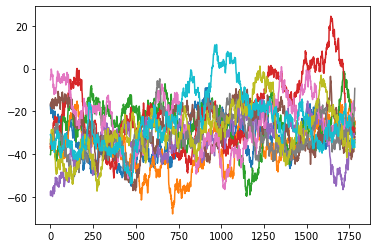

In [91]:
plt.plot(accepted_samples[:,:,0])

In [92]:
accepted_samples[:,:,0].shape

(1782, 10)

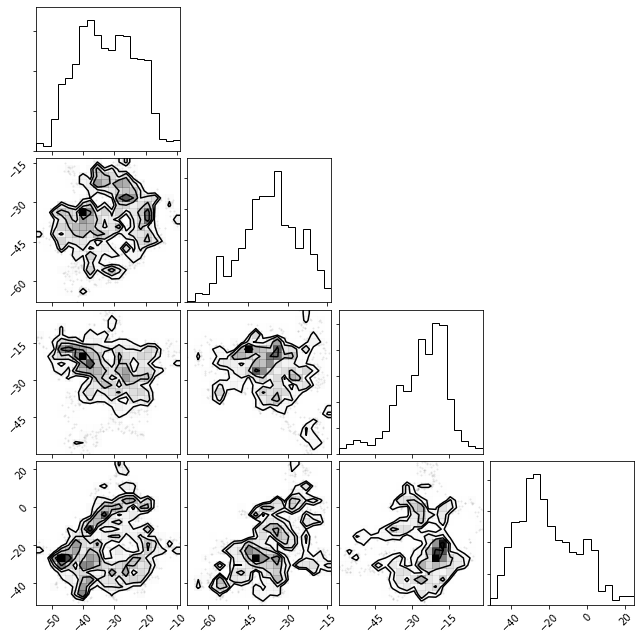

In [93]:
figure = corner.corner(accepted_samples[:,0:4,0])

TO DO:
1.  add a entropy plotting function
2.  compare with prior info and without
3.  Hessian MCMC

In [94]:
def draw_MCMC(base,samples,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots()
        
    base_ = copy.deepcopy(base)
    
    x_ = base_[:,0]
    z_ = base_[:,1]
    
    x = base[:,0]
    z = base[:,1]
    
    # plot the truth
    for i in range(base_.shape[0]):
        ax.plot(x[i:i+2],z[i:i+2],'k-')
    x1 = np.linspace(-R,R,N)
    
    
    for ps in samples:
        
        ps1 = ps
        ps2 = ps1-thickness
        ps2 = list(reversed(ps2))

        for i in range(2,N+2): ## lower layer
            base_[i][1] = ps2[i-2]

        for i in range(N+6,2*N+6): ## upper layer
            base_[i][1] = ps1[i-N-6]
            
        for i in range(N+5,base_.shape[0]-1):
            ax.plot(base_[:,0][i:i+2],base_[:,1][i:i+2],'r-',alpha = 0.01)
    
    ax.plot(x1,np.zeros(np.shape(x1)),lw = 0.5)# draw a reference line, surface
    ax.plot([x[0],x[-1]],[z[0],z[-1]],'k-')# draw the truth
    ax.set_ylim(min(base[:,1])-10,5)
    ax.set_xlim(-R,R)

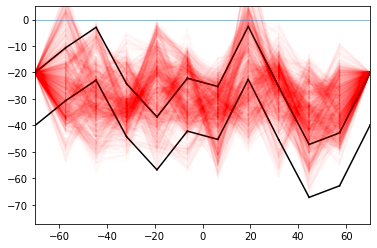

In [95]:
draw_MCMC(points,accepted_samples[:,:,0])
plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/RMH_layerlike.png')

Only sample from Prior distribution

In [96]:
def log_prior(D,points_copy,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.MultivariateNormalFullCovariance(
            loc = mu_prior,
            covariance_matrix= cov_prior)
    
    # return the posterior probability
    return(mvn_prior.log_prob(ps))

In [57]:
mu_prior

<tf.Tensor: id=4, shape=(10,), dtype=float32, numpy=
array([-30., -30., -30., -30., -30., -30., -30., -30., -30., -30.],
      dtype=float32)>

In [97]:
num_results = 2000
burnin = 0

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: log_prior(obs_data,points_copy,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_prior = samples[accept_index]


/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


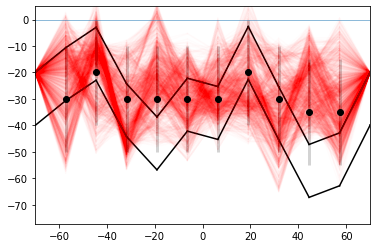

In [101]:
f,ax = plt.subplots(1)

x = points[:,0][N+6:-2]

dy = 20
np.random.seed(11)
# y = y_0 
y = mu_prior.numpy()
ax.errorbar(x, y, yerr=dy, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

draw_MCMC(points,accepted_samples_prior[:,:,0],ax)
plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/prior-layerlike.png')

if without prior info

In [992]:
low_ = -50*tf.ones(N)
high_ = -1*tf.ones(N)

In [993]:
cov

<tf.Tensor: id=38630179, shape=(9, 9), dtype=float32, numpy=
array([[9.e-14, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 9.e-14, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 9.e-14, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 9.e-14, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 9.e-14, 0.e+00, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 9.e-14, 0.e+00, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 9.e-14, 0.e+00,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 9.e-14,
        0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        9.e-14]], dtype=float32)>

In [994]:

def joint_log_prob(D,points_,ps):
    """
    D: is the observation data
    ps: is the variable point positions (N elements vector)
    """
    # define random variables prior
    mvn_prior = tfd.Uniform(
            low = low_,
            high = high_)
    # define likelihood
    
    Gm_ = grav(points_,ps)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(tf.reduce_sum(mvn_prior.log_prob(ps))
          +mvn_likelihood.log_prob(D))

In [995]:
points

array([[-200.        ,  -40.        ],
       [ -70.        ,  -40.        ],
       [ -57.27272727,  -30.65294507],
       [ -44.54545455,  -22.93481159],
       [ -31.81818182,  -44.23448927],
       [ -19.09090909,  -56.7968286 ],
       [  -6.36363636,  -42.16977302],
       [   6.36363636,  -45.30050071],
       [  19.09090909,  -22.6134791 ],
       [  31.81818182,  -45.39383715],
       [  44.54545455,  -67.20671931],
       [  57.27272727,  -62.83816429],
       [  70.        ,  -40.        ],
       [ 200.        ,  -40.        ],
       [ 200.        ,  -20.        ],
       [  70.        ,  -20.        ],
       [  57.27272727,  -42.83816429],
       [  44.54545455,  -47.20671931],
       [  31.81818182,  -25.39383715],
       [  19.09090909,   -2.6134791 ],
       [   6.36363636,  -25.30050071],
       [  -6.36363636,  -22.16977302],
       [ -19.09090909,  -36.7968286 ],
       [ -31.81818182,  -24.23448927],
       [ -44.54545455,   -2.93481159],
       [ -57.27272727,  -

In [ ]:
num_results = 2000
burnin = 1000

initial_chain_state = [
    -10 * tf.ones([N], dtype=tf.float32, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(obs_data,points_copy,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float32

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()


In [997]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

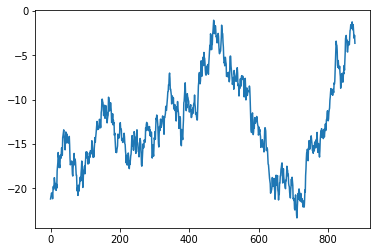

In [998]:
plt.plot(accepted_samples[:,0:1,0])

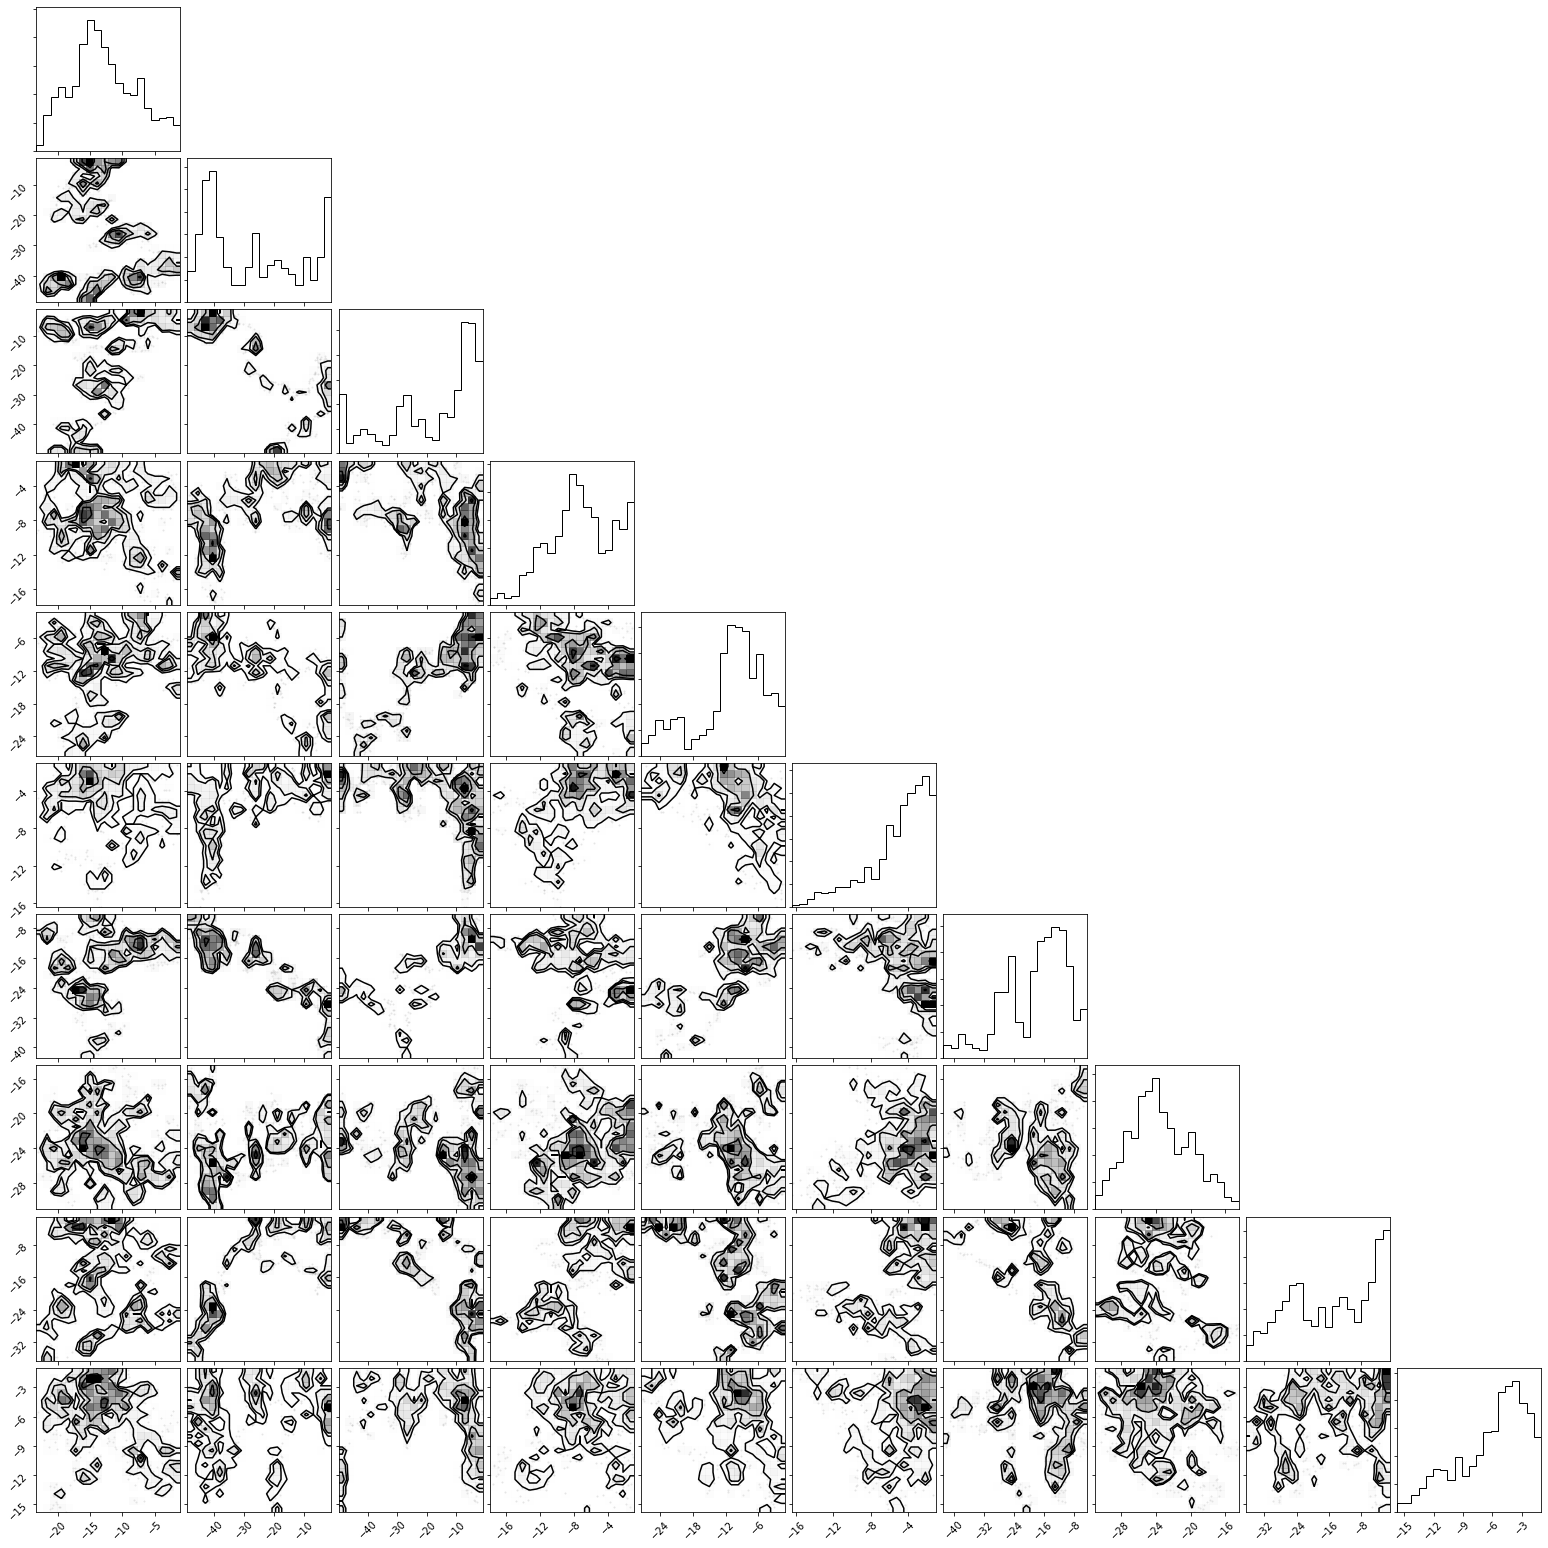

In [999]:
figure = corner.corner(accepted_samples[:,:,0])

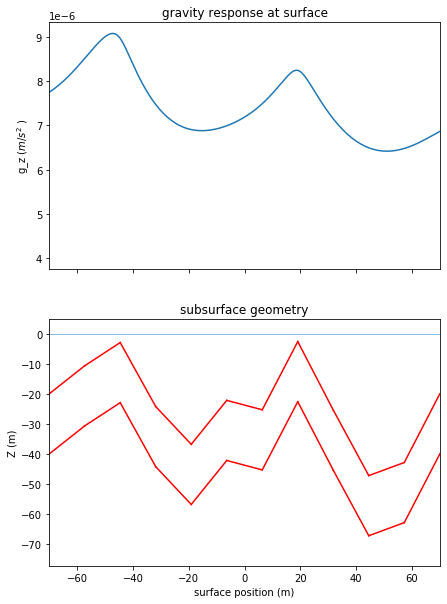

In [1000]:
plot_true(points,70)

In [1001]:
draw_MCMC(points,accepted_samples[:,:,0],R=70)
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/likelihood-layerlike.png')

In [1002]:
def joint_log_prob(D,points_copy,ps):

    # define likelihood
    
    Gm_ = grav(points_copy,ps)
    print(Gm_)
    Gm = tf.convert_to_tensor(Gm_,dtype)
    
    mvn_likelihood = tfd.MultivariateNormalFullCovariance(
            loc = Gm,
            covariance_matrix= cov)
    
    # return the posterior probability
    return(mvn_likelihood.log_prob(D))